<a href="https://colab.research.google.com/github/eshika289/cs301_project/blob/main/CS_301_Project_NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Statements

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

In [ ]:
import os, shutil
import csv
import re
import string
import math
import random
import numpy as np
import pandas as pd 
import itertools
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
from typing import List, Union
from typing import Any
from typing import Dict
from typing import TypeVar
from typing import NamedTuple, Optional

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Get Data From Kaggle

Get kaggle.json file from kaggle and upload it to the content folder

In [ ]:
!pwd # /content

/content


In [ ]:
!mkdir /root/.kaggle
!mkdir kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘kaggle’: File exists


In [ ]:
!mv ./kaggle.json /root/.kaggle/kaggle.json
#!cat /root/.kaggle/kaggle.json

mv: cannot stat './kaggle.json': No such file or directory


In [ ]:
#!pip install kaggle
!kaggle -v

Kaggle API 1.5.12


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions files -c nlp-getting-started

name                    size  creationDate         
---------------------  -----  -------------------  
test.csv               411KB  2019-12-16 20:36:20  
sample_submission.csv   22KB  2019-12-16 20:36:20  
train.csv              965KB  2019-12-16 20:36:20  


In [ ]:
!kaggle competitions download -c nlp-getting-started -p /content/kaggle/

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q /content/kaggle/nlp-getting-started.zip -d /content/kaggle/data

replace /content/kaggle/data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/kaggle/data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/kaggle/data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data_path = "kaggle/data/train.csv"
data_file = open(data_path)
read_file = csv.reader(data_file)
headers = []
headers = next(read_file)
data = []
for row in read_file:
  data.append(row)

In [ ]:
print(headers) # ['id', 'keyword', 'location', 'text', 'target']
print(data[0])
print(len(data))

['id', 'keyword', 'location', 'text', 'target']
['1', '', '', 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', '1']
7613


In [ ]:
def shuffle(array):
  array = np.random.permutation(array)
  return array

def split_data(data):
  global test_data, train_data
  test_data = data[5000:]
  train_data = data[:5000]

def shuffle_and_split(data):
  data = shuffle(data)
  split_data(data)
  
shuffle_and_split(data)

# Extract Features

## Link as Feature

In [ ]:
true = 0
false = 0
for item in data:
  link = False
  if 'http' in item[3]:
    link = True
    true+=1
  else:
    false+=1
  item.insert(4,link)
headers.insert(4,'link')

print("Number of Tweets with Links: " + str(true))
print("Number of Tweets without Links: " + str(false))

Number of Tweets with Links: 3971
Number of Tweets without Links: 3642


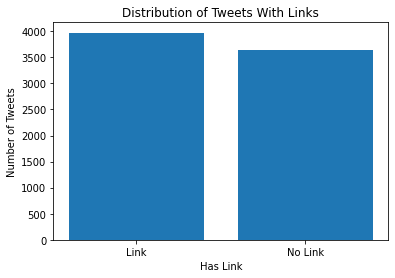

In [ ]:
plt.bar(['Link','No Link'], [true,false])
plt.title("Distribution of Tweets With Links")
plt.xlabel("Has Link")
plt.ylabel("Number of Tweets")
plt.show()

## Hashtags as Feature

In [ ]:
hashtag_nums = []
for item in data:
  hashtag = item[3].count('#')
  item.insert(5,hashtag)
  hashtag_nums.append(hashtag)
headers.insert(5,'num_hashtags')

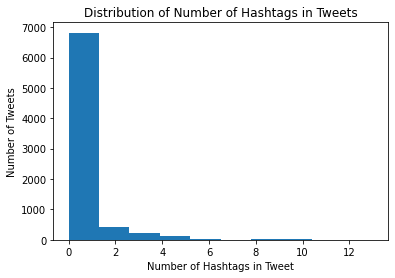

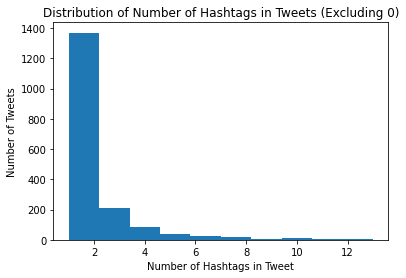

In [ ]:
plt.hist(hashtag_nums)
plt.title("Distribution of Number of Hashtags in Tweets")
plt.xlabel("Number of Hashtags in Tweet")
plt.ylabel("Number of Tweets")
plt.show()

print()

plt.hist([i for i in hashtag_nums if i != 0])
plt.title("Distribution of Number of Hashtags in Tweets (Excluding 0)")
plt.xlabel("Number of Hashtags in Tweet")
plt.ylabel("Number of Tweets")
plt.show()

## Number of Words & Characters Per Word

- num words
- num chars
- avg chars per word

### Num Words

In [ ]:
word_counts=[]
for item in data:
  words = len(item[3].split())
  w = 'other'
  if words in (1,2,3,4,5):
    w = '1-5'
  elif words in (6,7,8,9,10):
    w = '6-10'
  elif words in (11,12,13,14,15):
    w = '11-15'
  elif words in (16,17,18,19,20):
    w = '16-20'
  elif words in (21,22,23,24,25):
    w = '21-25'
  elif words in (26,27,28,29,30):
    w = '26-30'
  word_counts.append(words)
  item.insert(6,w)
headers.insert(6,'word_count')
print(data[100])

['144', 'accident', 'UK', '.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad', True, 1, '16-20', '1']


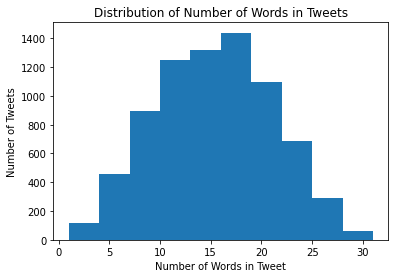

In [ ]:
plt.hist(word_counts)
plt.title("Distribution of Number of Words in Tweets")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Number of Tweets")
plt.show()

### Num Chars

In [ ]:
char_counts=[]
for item in data:
  chars = len(item[3])
  char_counts.append(chars)
  w = 'other'
  if chars in [x for x in range(1,21)]:
    w = '1-20'
  elif chars in [x for x in range(21,41)]:
    w = '21-40'
  elif chars in [x for x in range(41,61)]:
    w = '41-60'
  elif chars in [x for x in range(61,81)]:
    w = '61-80'
  elif chars in [x for x in range(81,101)]:
    w = '81-100'
  elif chars in [x for x in range(101,121)]:
    w = '101-120'
  elif chars in [x for x in range(121,141)]:
    w = '121-140'
  elif chars in [x for x in range(141,161)]:
    w = '141-160'
  item.insert(7,w)
headers.insert(7,'char_count')
print(data[100])

['144', 'accident', 'UK', '.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad', True, 1, '16-20', '121-140', '1']


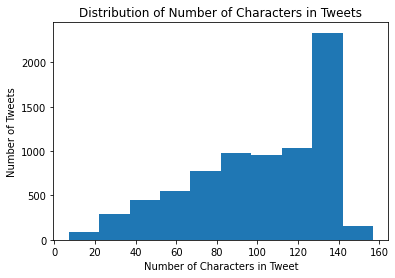

In [ ]:
plt.hist(char_counts)
plt.title("Distribution of Number of Characters in Tweets")
plt.xlabel("Number of Characters in Tweet")
plt.ylabel("Number of Tweets")
plt.show()

### Avg Chars Per Word

In [ ]:
avgs = []
for item in data:
  avg = round((len(item[3])-item[3].count(" "))/len(item[3].split()),1)
  avgs.append(avg)
  item.insert(8,avg)
headers.insert(8,'avg_char_per_word')
print(data[100])

['144', 'accident', 'UK', '.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad', True, 1, '16-20', '121-140', 6.4, '1']


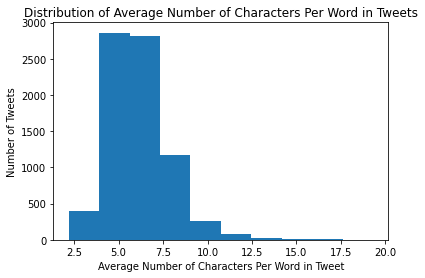

In [ ]:
plt.hist(avgs)
plt.title("Distribution of Average Number of Characters Per Word in Tweets")
plt.xlabel("Average Number of Characters Per Word in Tweet")
plt.ylabel("Number of Tweets")
plt.show()

## Most Common Words as Features

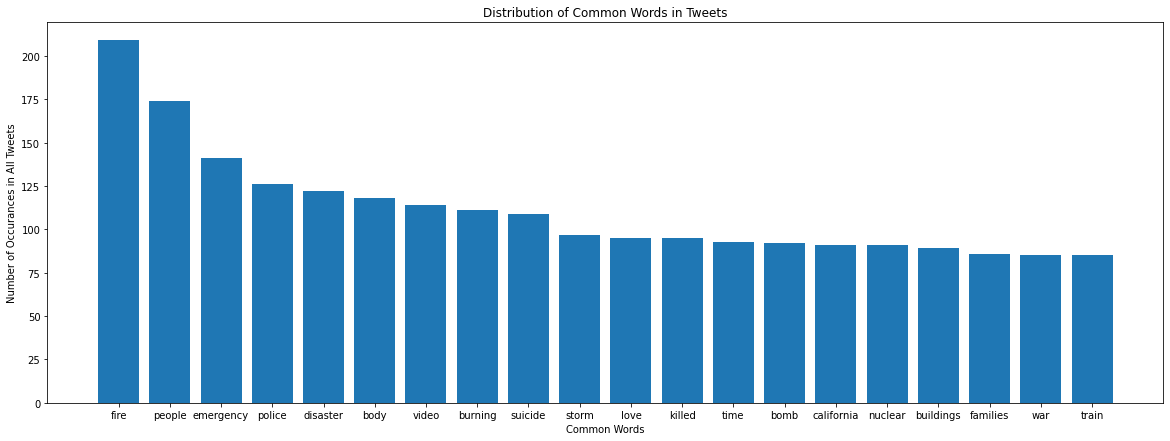

In [ ]:
def most_common_words(subset):
  all_text = ""
  for i in range(len(subset)):
    all_text+=subset[i][3]+" "

  stop_words = stopwords.words('english')
  stop_words += ['like',"i'm","get","new","via","one","would","still","got","back",'first','know','see','going','us','man','two','go','may',"can't",'full','last','rt','say','could','make','u','let','much','every']
  all_text.lower()
  words_list = all_text.split()
  word_list = []

  for word in words_list:
    word = word.lower()
    if word not in stop_words and re.search('[a-z]', word) is not None and word!="&amp;" and word[:4]!="http":
      #tmp = wn.synsets(word)[0].pos()
      word_list.append(word)
      #part_of_speech[word.lower]= tmp

  #words_dict = dict(sorted(words_dict.items(), key=lambda item: -item[1]))
  words_dict = Counter(word_list)
  words = words_dict.most_common(20)
  labels = [a for a,_ in words]
  values = [b for _,b in words]

  fig = plt.figure(figsize =(20, 7))
  # creating the bar plot
  plt.bar(labels, values)

  plt.xlabel("Common Words")
  plt.ylabel("Number of Occurances in All Tweets")
  plt.title("Distribution of Common Words in Tweets")
  plt.show()
 
  keywords2 = []
  for item in words_dict.most_common(100):
    keywords2.append(item[0])
  return keywords2

keywords2 = most_common_words(data)

In [ ]:
for item in data:
  val = 'none'
  for word in keywords2:
    if word in item[3].lower():
        val = word
        break
  item.insert(9,val)
        
headers.insert(9,'keyword2')

## Bigrams As Features

In [ ]:
bigrams = defaultdict(int)
data_bigrams = []
for item in data:
  tweet_text = re.sub(r'[^\w\s]', '', item[3]) # Remove Punctuation

  stop_words = stopwords.words('english')
  stop_words += ['like',"i'm","get","new","via","one","would","still","got","back",'first','know','see','going','us','man','two','go','may',"can't",'full','last','rt','say','could','make','u','let','much','every']
  w = tweet_text.split()
  r  = [word for word in w if word.lower() not in stop_words]
  tweet_text = ' '.join(r)  

  nltk_tokens = nltk.word_tokenize(tweet_text.lower())
  lst = list(nltk.bigrams(nltk_tokens))
  data_bigrams.append(lst)
  for bigram in lst:
    bigrams[bigram]+=1

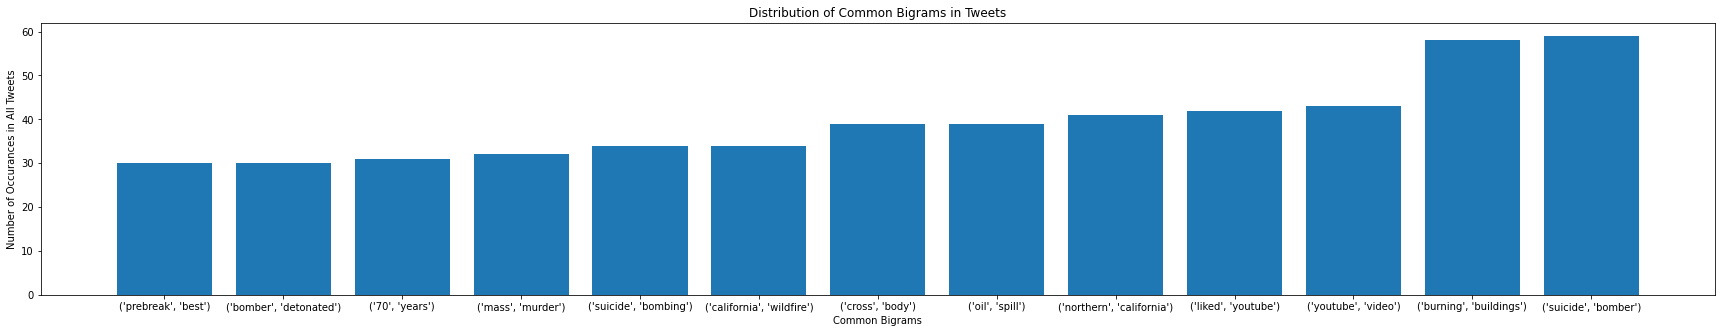

In [ ]:
common_bigrams = sorted(bigrams.items(), key=lambda item: item[1])
common_bigrams = common_bigrams[-100:]

bgs = common_bigrams[-15:]
labels = [str(a) for a,_ in bgs if a[1] != 'na']
values = [b for _,b in bgs if _[1] != 'na']

fig = plt.figure(figsize =(30, 5))
# creating the bar plot
plt.bar(labels, values)

plt.xlabel("Common Bigrams")
plt.ylabel("Number of Occurances in All Tweets")
plt.title("Distribution of Common Bigrams in Tweets")
plt.show()

common_bigrams = [(a,b) for (a,b) in reversed([x for x,_ in common_bigrams]) if 'http' not in a and 'http' not in b and 'amp' not in a and 'amp' not in b]
#common_bigrams.remove(('i', "'m"))
#common_bigrams.remove(('do', "n't"))
#common_bigrams.remove(('ca', "n't"))
common_bigrams.remove(('gon', "na"))
common_bigrams.remove(('wan', "na"))


In [ ]:
i=0
for item in data:
  val = 'none'
  for bigram in common_bigrams:
    if bigram in data_bigrams[i]:
        val = bigram
        break
  item.insert(10,val)
  i+=1

headers.insert(10,'bigrams')

## Feature List

- keyword (data[x][1])
- location (data[x][2])
- link (data[x][4])
- num hashtags (data[x][5])
- num words (data[x][6])
- num chars (data[x][7])
- avg chars per word (data[x][8])
- keyword2 (data[x][9])
- common bigrams (data[x][10])



In [ ]:
feature_nums = [1,2,4,5,6,7,8,9,10]
target_num = [-1]
nums = feature_nums + target_num
features = []
for num in feature_nums:
  features.append(headers[num])

In [ ]:
shuffle_and_split(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


# Decision Tree

Citation

Entropy, Parition, Build Tree Sections (with some modifications)
- Data Science from Scratch: First Principles with Python (GRUS Textbook) 

## Entropy

In [ ]:
def entropy(class_probabilities: List[float]) -> float:
  '''Given a list of class probabilities, compute the entropy'''
  return jnp.sum(jnp.asarray([-p*jnp.log2(p) for p in class_probabilities if p > 0]))

def class_probabilities(labels: List[Any]) -> float:
  total_count = jnp.size(labels)
  return [count/total_count for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
  return entropy(class_probabilities(labels))

def partition_entropy(subsets: List[List[Any]]) -> float:
  '''Returns the entropy from this partition of data into subsets'''
  total_count = jnp.sum(jnp.asarray([jnp.size(subset) for subset in subsets]))
  return jnp.sum(jnp.asarray([data_entropy(subset)*jnp.size(subset)/total_count for subset in subsets]))

## Parition

In [ ]:
T = TypeVar('T')

def partition_by(inputs: List[T], attribute:str) -> Dict[Any, List[T]]:
  '''Partitions the inputs into lists based on the specified attribute'''
  partitions: Dict[Any,List[T]] = defaultdict(list)
  for input in inputs:
    key = getattr(input, attribute)
    partitions[key].append(input)
  return partitions

def partition_entropy_by(inputs: List[Any], attribute:str,label_attribute:str) ->float:
  '''Computes the entropy corresponding to the given partition'''
  partitions = partition_by(inputs,attribute)
  labels = [[getattr(input, label_attribute) for input in partition] for partition in partitions.values()]
  return partition_entropy(labels)

## Test Entropy and Partition

In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


In [ ]:
train_tweets = []

class Tweet(NamedTuple):
  keyword: str
  location: str
  link: bool
  num_hashtags: int
  word_count: str
  char_count: str
  avg_char_per_word: float
  keyword2: str
  bigrams: tuple
  target: int

for tweet in train_data:
  train_tweets.append(Tweet(tweet[1],tweet[2],tweet[4],tweet[5],tweet[6],tweet[7],tweet[8],tweet[9],tweet[10],tweet[-1]))

In [ ]:
def createTweetsObjects():
  global train_data,test_data,train_tweets,test_tweets
  train_tweets = []
  test_tweets = []
  for tweet in train_data:
    train_tweets.append(Tweet(tweet[1],tweet[2],tweet[4],tweet[5],tweet[6],tweet[7],tweet[8],tweet[9],tweet[10],tweet[-1]))
  for tweet in test_data:
    test_tweets.append(Tweet(tweet[1],tweet[2],tweet[4],tweet[5],tweet[6],tweet[7],tweet[8],tweet[9],tweet[10],tweet[-1]))

In [ ]:
createTweetsObjects()

In [ ]:
print(len(train_tweets))
print(len(train_data))

5000
5000


Inital Entropy of Features
keyword 0.7221234
location 0.50415874
link 0.9368526
num_hashtags 0.9778624
word_count 0.9652788
char_count 0.9519294
avg_char_per_word 0.9071006
keyword2 0.8465205
bigrams 0.8876663


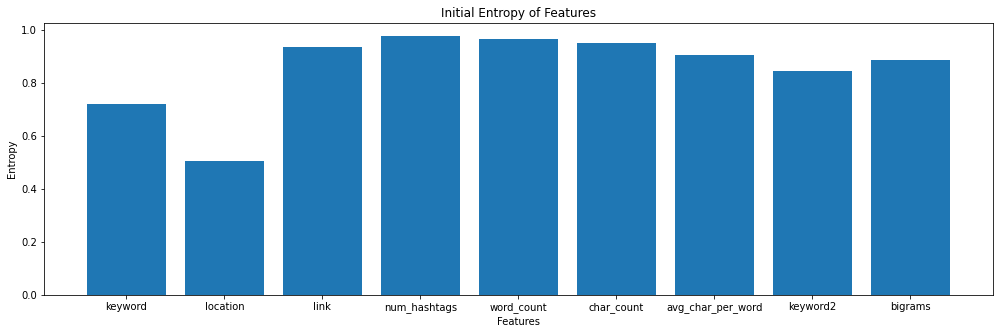

In [ ]:
print("Inital Entropy of Features")
entropies = []
for key in features:
  entrpy = partition_entropy_by(train_tweets,key,'target')
  entropies.append(entrpy)
  print(key,entrpy)

fig = plt.figure(figsize =(17, 5))

plt.bar([key for key in features], entropies)

plt.xlabel("Features")
plt.ylabel("Entropy")
plt.title("Initial Entropy of Features")
plt.show()

## Build Tree

In [ ]:
class Leaf(NamedTuple):
  value: Any

class Split(NamedTuple):
  attribute: str
  subtrees: dict
  default_value: Any = None

DecisionTree = Union[Leaf,Split]

In [ ]:
class Tweet(NamedTuple):
  keyword: str
  location: str
  target: int

In [ ]:
def classify(tree:DecisionTree,input:Any) -> Any:
  '''Classify the input using the given decision tree'''
  
  # If this is a leaf node, return its value
  if isinstance(tree,Leaf):
    return tree.value

  subtree_key = getattr(input, tree.attribute)

  if subtree_key not in tree.subtrees:
    return tree.default_value
  
  subtree = tree.subtrees[subtree_key]
  return classify(subtree,input)

In [ ]:
def build_tree_id3(inputs: List[Any],split_attributes:List[str],target_attribute:str)->DecisionTree:
  # Count target labels
  label_counts = Counter(getattr(input,target_attribute) for input in inputs)
  most_common_label = label_counts.most_common(1)[0][0]

  # If there's a unique label, predict it
  if len(label_counts) == 1:
    return Leaf(most_common_label)
  
  # If no split attributes left, return the majority label
  if not split_attributes:
    return Leaf(most_common_label)

  # Otherwise split by the best attribute
  def split_entropy(attribute:str) -> float:
    return partition_entropy_by(inputs,attribute,target_attribute)
  
  best_attribute = min(split_attributes, key=split_entropy)

  partitions = partition_by(inputs, best_attribute)
  new_attributes = [a for a in split_attributes if a !=best_attribute]

  # Recursively build subtrees
  subtrees = {attribute_value: build_tree_id3(subset,new_attributes, target_attribute) for attribute_value,subset in partitions.items()}

  return Split(best_attribute, subtrees, default_value=most_common_label)

## Test Build Tree

In [ ]:
decision_tree = build_tree_id3(train_tweets,['keyword2','num_hashtags'],'target')
print(decision_tree)

Split(attribute='keyword2', subtrees={'emergency': Split(attribute='num_hashtags', subtrees={2: Leaf(value='1'), 1: Leaf(value='1'), 0: Leaf(value='1'), 5: Leaf(value='0'), 3: Leaf(value='0'), 6: Leaf(value='0'), 4: Leaf(value='0')}, default_value='1'), 'time': Split(attribute='num_hashtags', subtrees={0: Leaf(value='0'), 2: Leaf(value='1'), 1: Leaf(value='0'), 3: Leaf(value='1'), 4: Leaf(value='0')}, default_value='0'), 'fire': Split(attribute='num_hashtags', subtrees={0: Leaf(value='1'), 1: Leaf(value='1'), 2: Leaf(value='1'), 6: Leaf(value='1'), 3: Leaf(value='1'), 5: Leaf(value='0'), 4: Leaf(value='1')}, default_value='1'), 'news': Split(attribute='num_hashtags', subtrees={0: Leaf(value='0'), 1: Leaf(value='1'), 2: Leaf(value='1'), 3: Leaf(value='1'), 10: Leaf(value='0'), 13: Leaf(value='1')}, default_value='1'), 'im': Split(attribute='num_hashtags', subtrees={1: Leaf(value='0'), 0: Leaf(value='0'), 3: Leaf(value='1'), 2: Leaf(value='0'), 6: Leaf(value='0'), 5: Leaf(value='0'), 4: 

In [ ]:
def num_leaves(decision_tree):
  leaves = 0
  stack = [decision_tree]
  while stack:
    tree= stack.pop()
    if isinstance(tree,Leaf):
      leaves+=1
    else:
      for item in tree[1]:
        stack.append(tree[1][item])
  return leaves

print("Number of Leaves in Decision Tree:",num_leaves(decision_tree))

Number of Leaves in Decision Tree: 337


## Accuracy of Tree

In [ ]:
def accuracy(decision_tree,tweets):
  correct = 0
  incorrect = 0
  for tweet in tweets:
    predictedOutput(decision_tree,tweet)
    if value== tweet.target:
      correct+=1
    else:
      incorrect+=1
  #print("Correct: ", correct)
  #print("Incorrect: ", incorrect)

  accuracy = correct/(correct+incorrect)
  #print("Accuracy: ", accuracy)
  return accuracy


def predictedOutput(decision_tree,tweet):
  ''' will use the decision_tree to predict if tweet is valid or not
      changes the global variable value to 1 for valid and 0 for invalid
  '''
  global value
  tree= decision_tree
  attribute = tree[0]
  tweet_val = tweet[features.index(attribute)]
  try:
    tree = tree[1][tweet_val]
    if isinstance(tree,Leaf):
        value = tree.value
    else:
      predictedOutput(tree,tweet)
  except:
    value = tree[2]

In [ ]:
print("Training Data Accuracy: ", end="")
print(accuracy(decision_tree,train_tweets))
print("Test Data Accuracy: ", end="")
print(accuracy(decision_tree,test_tweets))
#predictedOutput(decision_tree,tweets[0])

Training Data Accuracy: 0.7158
Test Data Accuracy: 0.6766169154228856


## Precision and Recall of Tree

In [ ]:
def precision(decision_tree,tweets):
  num = 0
  denom = 0
  for tweet in tweets:
    global value
    predictedOutput(decision_tree,tweet)
    if value== '1':
      denom+=1
      if tweet.target=='1':
        num+=1
  precision = num/denom
  return precision

In [ ]:
print("Training Data Precision: ", end="")
print(precision(decision_tree,train_tweets))
print("Test Data Precision: ", end="")
print(precision(decision_tree,test_tweets))

Training Data Precision: 0.6947075208913649
Test Data Precision: 0.6613924050632911


In [ ]:
def recall(decision_tree,tweets):
  num = 0
  denom = 0
  for tweet in tweets:
    global value
    predictedOutput(decision_tree,tweet)
    if value== '1' and tweet.target=='1':
      num+=1
      denom+=1
    if value=='0' and tweet.target=='1':
      denom+=1
  recall = num/denom
  return recall

In [ ]:
print("Training Data Recall: ", end="")
print(recall(decision_tree,train_tweets))
print("Test Data Recall: ", end="")
print(recall(decision_tree,test_tweets))

Training Data Recall: 0.5882075471698113
Test Data Recall: 0.5447437011294527


## Functions to Use to Build Trees 



*   build_tree_id3(tweets,['keyword','location'],'target') -> returns a decision tree
*   predictedOutput(tree,tweet) -> changes the global variable value to 1 if valid and 0 if not valid
*   decision_tree_accuracies(tree,train_tweets,test_tweets) -> returns the train and test accuracies as a tuple (train_accuracy,test_accuracy)


In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


In [ ]:
tree_features = ['keyword', 'bigrams']

In [ ]:
class Tweet(NamedTuple):
  keyword: str
  location: str
  link: bool
  num_hashtags: int
  word_count: str
  char_count: str
  avg_char_per_word: float
  keyword2: str
  bigrams: tuple
  target: int

In [ ]:
shuffle_and_split(data)
createTweetsObjects() # if this produces an error refresh the cell that declares the Tweet class in the test entropy and partition sections
tree = build_tree_id3(train_tweets,tree_features,'target')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
predictedOutput(tree,train_tweets[100])
print("Predicted Value: ",value)
print("Actual Value: ", train_tweets[100].target)

predictedOutput(tree,train_tweets[40])
print("Predicted Value: ",value)
print("Actual Value: ", train_tweets[40].target)

Predicted Value:  0
Actual Value:  0
Predicted Value:  1
Actual Value:  0


In [ ]:
print("Number of Leaves in Decision Tree:", num_leaves(tree))

Number of Leaves in Decision Tree: 323


In [ ]:
def decision_tree_accuracies(tree,train_tweets,test_tweets):
  one = accuracy(tree,train_tweets)
  two = accuracy(tree,test_tweets)
  #print("train acc:",one)
  #print("test acc:",two)
  return(one,two)


In [ ]:
train_acc,test_acc = decision_tree_accuracies(tree,train_tweets,test_tweets)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.7526
Test Accuracy: 0.7416762342135477


## Tree Predicting a Tweet (Example)

See How a Decision Tree Will Predict if the Following Tweet is Valid or Not

In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


In [ ]:
tweet = Tweet(keyword='apocalypse', location='', link=False, num_hashtags=0, word_count='6-10', char_count='41-60', avg_char_per_word=6.1, keyword2='day', bigrams='none', target='0')

In [ ]:
test_features = ['location','link', 'num_hashtags', 'word_count', 'char_count', 'bigrams']
decision_tree = build_tree_id3(train_tweets,test_features,'target')

Split 1 : location
Tweet => location => empty string
Entropy location : 0.5080663
Entropy link : 0.938406
Entropy num_hashtags : 0.97577345
Entropy word_count : 0.9673147
Entropy char_count : 0.9559908
Entropy bigrams : 0.8894241


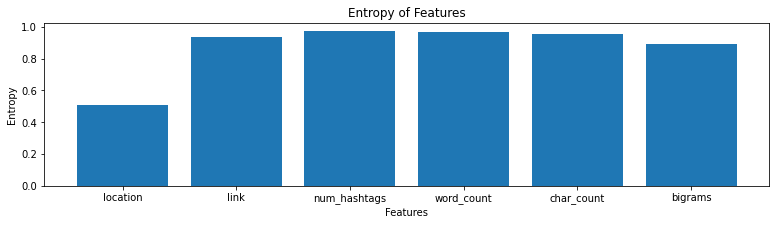


Split 2 : bigrams
Tweet => bigrams => none
Entropy link : 0.93550897
Entropy num_hashtags : 0.96815926
Entropy word_count : 0.95906067
Entropy char_count : 0.9468864
Entropy bigrams : 0.8611812


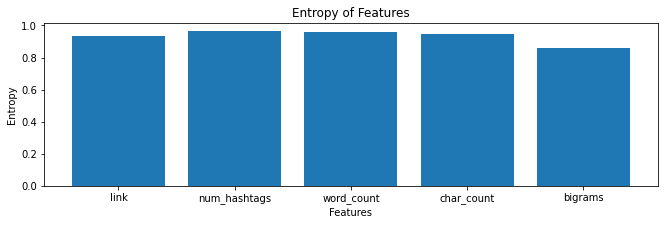


Split 3 : link
Tweet => link => False
Entropy link : 0.90900064
Entropy num_hashtags : 0.9389436
Entropy word_count : 0.93967414
Entropy char_count : 0.92722255


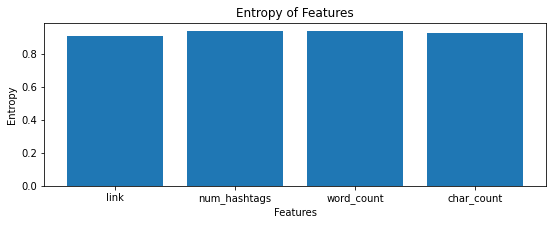


Split 4 : num_hashtags
Tweet => num_hashtags => 0
Entropy num_hashtags : 0.807024
Entropy word_count : 0.8153536
Entropy char_count : 0.81515574


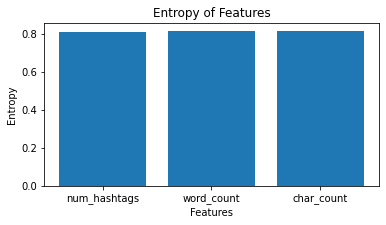


Split 5 : char_count
Tweet => char_count => 41-60
Entropy word_count : 0.77904963
Entropy char_count : 0.77734494


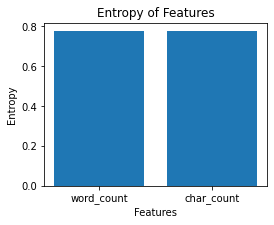


Split 6 : word_count
Tweet => word_count => 6-10
Entropy word_count : 0.6720335


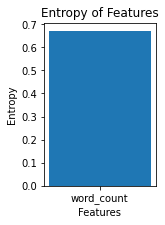


Tree: Leaf(value='0')
Prediction: 0
Actual Value: 0


In [ ]:
feats = test_features
tweets_entropy = train_tweets
for split in range(1,len(test_features)+1):
  #print("Tree:",decision_tree)
  attr = decision_tree[0]
  print("Split",split,":",attr )
  num=0
  for i in range(9):
    if features[i]==attr:
      num = i
      break
  val = a = tweet[num]
  if val=="":
    val = "empty string"
  print("Tweet =>",attr, "=>",val)
  try:
    decision_tree = decision_tree[1][tweet[num]]
    prediction = decision_tree[0]
  except:
    print("Value for this tweet feature not in tree")
    print("Default Value is ",decision_tree[2])
    prediction=decision_tree[2]
    print()
    break

  # Plot
  entropies = []
  for key in feats:
    entrpy = partition_entropy_by(tweets_entropy,key,'target')
    entropies.append(entrpy)
    print("Entropy",key,":",entrpy)

  tweets_entropy = [item for item in tweets_entropy if item[num]==a]
  

  fig = plt.figure(figsize =(int(2.3*len(feats)), 3))

  plt.bar([key for key in feats], entropies)

  plt.xlabel("Features")
  plt.ylabel("Entropy")
  plt.title("Entropy of Features")
  plt.show()

  feats.remove(attr)
  print()

print("Tree:",decision_tree)
print("Prediction:",prediction)
print("Actual Value:", tweet.target)

## Prevent Overfitting

In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


When we use all the features, the average number of tweets per leaf is about 1 or 2.  Thus, the data is being overfit.  To prevent this, we can lower the number of features per decision tree and use random forests to combine the results of the trees.

In [ ]:
tree_features = features
shuffle_and_split(data)
createTweetsObjects() # if this produces an error refresh the cell that declares the Tweet class in the test entropy and partition sections
tree = build_tree_id3(train_tweets,tree_features,'target')
leaves_9 = num_leaves(tree)
print("Number of Leaves in Decision Tree:", leaves_9)
print("Average Number of Tweets Per Leaf in Decision Tree:", len(train_tweets)/leaves_9)
decision_tree_accuracies(tree,train_tweets,test_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Number of Leaves in Decision Tree: 4073
Average Number of Tweets Per Leaf in Decision Tree: 1.2275963663147558


(0.9946, 0.6364332185227708)

One Feature.

In [ ]:
tree_features = ['keyword2']
shuffle_and_split(data)
createTweetsObjects() # if this produces an error refresh the cell that declares the Tweet class in the test entropy and partition sections
tree = build_tree_id3(train_tweets,tree_features,'target')
leaves_1 = num_leaves(tree)
print("Number of Leaves in Decision Tree:", leaves_1)
print("Average Number of Tweets Per Leaf in Decision Tree:", len(train_tweets)/leaves_1)
print()
decision_tree_accuracies(tree,train_tweets,test_tweets)

Number of Leaves in Decision Tree: 91
Average Number of Tweets Per Leaf in Decision Tree: 54.94505494505494



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(0.7028, 0.6804439341752775)

Two Features.

In [ ]:
tree_features = ['link','keyword2']
shuffle_and_split(data)
createTweetsObjects() # if this produces an error refresh the cell that declares the Tweet class in the test entropy and partition sections
tree = build_tree_id3(train_tweets,tree_features,'target')
leaves_2 = num_leaves(tree)
print("Number of Leaves in Decision Tree:", leaves_2)
print("Average Number of Tweets Per Leaf in Decision Tree:", len(train_tweets)/leaves_2)
decision_tree_accuracies(tree,train_tweets,test_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Number of Leaves in Decision Tree: 172
Average Number of Tweets Per Leaf in Decision Tree: 29.069767441860463


(0.7208, 0.6988136241867585)

Three Features.

In [ ]:
tree_features = ['link','num_hashtags','keyword2']
shuffle_and_split(data)
createTweetsObjects() # if this produces an error refresh the cell that declares the Tweet class in the test entropy and partition sections
tree = build_tree_id3(train_tweets,tree_features,'target')
leaves_3 = num_leaves(tree)
print("Number of Leaves in Decision Tree:", leaves_3)
print("Average Number of Tweets Per Leaf in Decision Tree:", len(train_tweets)/leaves_3)
decision_tree_accuracies(tree,train_tweets,test_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Number of Leaves in Decision Tree: 467
Average Number of Tweets Per Leaf in Decision Tree: 10.70663811563169


(0.743, 0.6911595866819747)

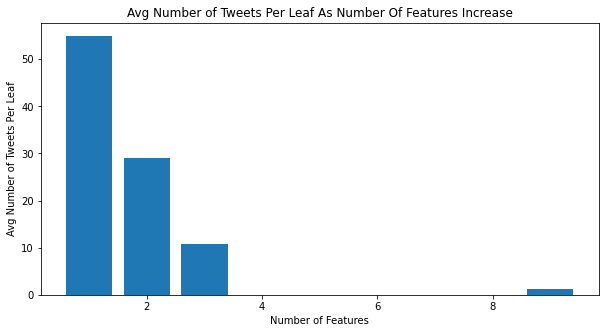

In [ ]:
values = [leaves_1,leaves_2,leaves_3,leaves_9]
values = [len(train_tweets)/l for l in values]
labels = [1,2,3,9]

fig = plt.figure(figsize =(10, 5))

plt.bar(labels, values)

plt.xlabel("Number of Features")
plt.ylabel("Avg Number of Tweets Per Leaf")
plt.title("Avg Number of Tweets Per Leaf As Number Of Features Increase")
plt.show()

Based off the analysis above, we will use trees that have 2-3 features (more specifically a higher average of tweets per leaf) to prevent overfitting the training data.

## Kaggle Submission

In [ ]:
test_data_path = "kaggle/data/test.csv"
test_data_file = open(test_data_path)
read_file = csv.reader(test_data_file)
_ = next(read_file)
submit_data = []
for row in read_file:
  submit_data.append(row)
print(len(submit_data))

3263


In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


In [ ]:
test_features = ['location','keyword']
tree = build_tree_id3(train_tweets,test_features,'target')

In [ ]:
submit_tweets = []
for tweet in submit_data:
  # link
  link = 'http' in tweet[3]
  
  # num_hashtags
  num_hashtags = tweet[3].count('#')
  
  # word_count
  words = len(tweet[3].split())
  w = 'other'
  if words in (1,2,3,4,5):
    w = '1-5'
  elif words in (6,7,8,9,10):
    w = '6-10'
  elif words in (11,12,13,14,15):
    w = '11-15'
  elif words in (16,17,18,19,20):
    w = '16-20'
  elif words in (21,22,23,24,25):
    w = '21-25'
  elif words in (26,27,28,29,30):
    w = '26-30'

  # char_count
  chars = len(tweet[3])
  char_counts.append(chars)
  c = 'other'
  if chars in [x for x in range(1,21)]:
    c = '1-20'
  elif chars in [x for x in range(21,41)]:
    c = '21-40'
  elif chars in [x for x in range(41,61)]:
    c = '41-60'
  elif chars in [x for x in range(61,81)]:
    c = '61-80'
  elif chars in [x for x in range(81,101)]:
    c = '81-100'
  elif chars in [x for x in range(101,121)]:
    c = '101-120'
  elif chars in [x for x in range(121,141)]:
    c = '121-140'
  elif chars in [x for x in range(141,161)]:
    c = '141-160'
  
  # avg_chars_per_word
  avg = round((len(item[3])-item[3].count(" "))/len(item[3].split()),1)

  # keyword2
  kw2 = 'none'
  for word in keywords2:
    if word in tweet[3].lower():
        kw2 = word
        break

  # bigrams
  bg = 'none'
  for bigram in common_bigrams:
    if bigram[0] in tweet[3] and bigram[1] in tweet[3]:
        bg = bigram
        break

  submit_tweets.append(Tweet(tweet[1],tweet[2],link,num_hashtags,w,c,avg,kw2,bg,'-1'))

In [ ]:
submit_targets = []
for i in range(len(submit_tweets)):
  predictedOutput(tree,submit_tweets[i])
  submit_targets.append(value)

In [ ]:
submit_targets.count('1')

830

In [ ]:
df = pd.read_csv("kaggle/data/sample_submission.csv")
for i in range(len(submit_targets)):
  df.loc[i, 'target'] = int(submit_targets[i])
df.to_csv("kaggle/data/sample_submission.csv", index = False)

Be careful - only 5 submissions allowed per day per user

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f kaggle/data/sample_submission.csv -m "Single Decision Tree"

100% 22.2k/22.2k [00:00<00:00, 51.0kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [ ]:
!kaggle competitions submissions -c nlp-getting-started

fileName                   date                 description                                      status    publicScore  privateScore  
-------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
sample_submission.csv      2022-04-25 03:51:14  Single Decision Tree                             complete  0.65430                    
sample_submission.csv      2022-04-25 03:45:00                                                   complete  0.71713                    
sample_submission.csv      2022-04-25 03:41:47  Random Forest (60 Trees) : Optimal Feature Mix   complete  0.74777                    
sample_submission (3).csv  2022-04-24 23:53:07   RandomForestClassifier()                        complete  0.77536                    
sample_submission (2).csv  2022-04-24 06:52:44  Random Forest (60 Tress): Optimal Feature Mix    complete  0.74992                    
sample_submission (1).csv  2022-04-24 06:40:26  Random 

Each individual decision tree has varying accuracies depending on the features they use and the training data they use.  It is typically between 60-70%.

publicScore is the accuracy of the kaggle test data

# Random Forests

## Build Trees

In [ ]:
print(features)

['keyword', 'location', 'link', 'num_hashtags', 'word_count', 'char_count', 'avg_char_per_word', 'keyword2', 'bigrams']


In [ ]:
shuffle_and_split(data)
createTweetsObjects()
tree_features = ['keyword','bigrams'] # can change this to get tree made from different features
tree = build_tree_id3(train_tweets,tree_features,'target')
train_acc,test_acc = decision_tree_accuracies(tree,train_tweets,test_tweets)
print("Train acc:",train_acc)
print("Test acc:",test_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train acc: 0.7582
Test acc: 0.7313432835820896


### Most Optimal Trees with 1,2, or 3 Features

In [ ]:
list1 = [0,1,2,3,4,5,6,7,8]

perm = []

for i in range(1,4):
    perm.extend(list(itertools.combinations(list1, r=i)))
print(len(perm))

129


In [ ]:
trees = []
tree_stats = {}
shuffle_and_split(data)
for comb in perm:
  feats = [features[i] for i in comb]
  #print(feats)
  
  t = build_tree_id3(train_tweets,feats,'target')
  if(5000/num_leaves(t)<5):
    continue

  trees.append(feats)
  acc = (decision_tree_accuracies(t,train_tweets,test_tweets)[1]) # if this produces an error rerun the accuracy function cell in the accuracy of tree section
  tree_stats[str(feats)] = acc
  #print()

x = sorted(tree_stats.items(), key=lambda item: -item[1])
x = x[:20]
feat_set_str = [a for a,_ in x]
best_performing_feature_sets = [a for a in trees if str(a) in feat_set_str]
print(best_performing_feature_sets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


[['keyword'], ['keyword2'], ['keyword', 'link'], ['keyword', 'num_hashtags'], ['keyword', 'bigrams'], ['link', 'keyword2'], ['num_hashtags', 'keyword2'], ['word_count', 'keyword2'], ['keyword2', 'bigrams'], ['keyword', 'link', 'num_hashtags'], ['keyword', 'link', 'bigrams'], ['keyword', 'num_hashtags', 'bigrams'], ['link', 'num_hashtags', 'keyword2'], ['link', 'word_count', 'keyword2'], ['link', 'char_count', 'keyword2'], ['link', 'keyword2', 'bigrams'], ['num_hashtags', 'word_count', 'keyword2'], ['num_hashtags', 'keyword2', 'bigrams'], ['word_count', 'keyword2', 'bigrams'], ['char_count', 'keyword2', 'bigrams']]


The cell above runs for about 3 minutes because it builds and evualtes the accuracy of 129 decision trees.


If you want to skip it, then set the best_performing_feature_sets variable manually with the cell below

In [ ]:
#best_performing_feature_sets = [['keyword'], ['keyword2'], ['keyword', 'link'], ['keyword', 'num_hashtags'], ['keyword', 'bigrams'], ['link', 'keyword2'], ['num_hashtags', 'keyword2'], ['word_count', 'keyword2'], ['keyword2', 'bigrams'], ['keyword', 'link', 'num_hashtags'], ['keyword', 'link', 'bigrams'], ['keyword', 'num_hashtags', 'bigrams'], ['link', 'num_hashtags', 'keyword2'], ['link', 'word_count', 'keyword2'], ['link', 'char_count', 'keyword2'], ['link', 'keyword2', 'bigrams'], ['num_hashtags', 'word_count', 'keyword2'], ['num_hashtags', 'keyword2', 'bigrams'], ['word_count', 'keyword2', 'bigrams'], ['char_count', 'keyword2', 'bigrams']]

In [ ]:
trees = []
shuffle_and_split(data)
test_accs = []
for i in range(10):
  for j in range(3):
    shuffle_and_split(data)
    createTweetsObjects()
    trees.append(build_tree_id3(train_tweets,best_performing_feature_sets[i],'target'))
    train_acc,test_acc = decision_tree_accuracies(trees[len(trees)-1],train_tweets,test_tweets) # if this produces an error rerun the accuracy function cell in the accuracy of tree section
    print("Train accuracy:",train_acc,"Test accuracy:",test_acc) 
    test_accs.append(test_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train accuracy: 0.7468 Test accuracy: 0.7313432835820896
Train accuracy: 0.749 Test accuracy: 0.730195177956372
Train accuracy: 0.7386 Test accuracy: 0.7470340604668962
Train accuracy: 0.6934 Test accuracy: 0.6949866054343666
Train accuracy: 0.7008 Test accuracy: 0.6800612323000382
Train accuracy: 0.6932 Test accuracy: 0.6961347110600842
Train accuracy: 0.7714 Test accuracy: 0.7393800229621125
Train accuracy: 0.7714 Test accuracy: 0.7374665135859165
Train accuracy: 0.7728 Test accuracy: 0.7455032529659396
Train accuracy: 0.7808 Test accuracy: 0.7106773823191733
Train accuracy: 0.7732 Test accuracy: 0.7125908916953693
Train accuracy: 0.7808 Test accuracy: 0.7141216991963261
Train accuracy: 0.758 Test accuracy: 0.7248373517030233
Train accuracy: 0.7558 Test accuracy: 0.7252200535782626
Train accuracy: 0.7624 Test accuracy: 0.7168006123230004
Train accuracy: 0.7248 Test accuracy: 0.6900114810562572
Train accuracy: 0.7228 Test accuracy: 0.6926903941829315
Train accuracy: 0.721 Test accurac

### Kaggle Submission Hard Coded Random Forest

In [ ]:
outputs=[]
for i in range(len(trees)):
  outputs.append([])
  for j in range(len(submit_tweets)):
    predictedOutput(trees[i],submit_tweets[j])
    outputs[i].append(value)
len(outputs[i])

3263

In [ ]:
len(trees)

30

In [ ]:
output = []
for i in range(len(outputs[i])):
  zero = 0
  one = 0
  for j in range(len(trees)):
    if outputs[j][i]=='0':
      zero+=test_accs[j]*1000
    else:
      one+=test_accs[j]*1000
  if zero>one:
    output.append(0)
  else:
    output.append(1)

print(output.count(1))

1143


In [ ]:
df = pd.read_csv("kaggle/data/sample_submission.csv")
for i in range(len(output)):
  df.loc[i, 'target'] = int(output[i])
df.to_csv("kaggle/data/sample_submission.csv", index = False)

In [ ]:
#!kaggle competitions submit -c nlp-getting-started -f kaggle/data/sample_submission.csv -m "Random Forest (60 Trees) : Optimal Feature Mix"

100% 22.2k/22.2k [00:00<00:00, 50.2kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [ ]:
!kaggle competitions submissions -c nlp-getting-started

fileName                   date                 description                                      status    publicScore  privateScore  
-------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
sample_submission.csv      2022-04-25 03:51:14  Single Decision Tree                             complete  0.65430                    
sample_submission.csv      2022-04-25 03:45:00                                                   complete  0.71713                    
sample_submission.csv      2022-04-25 03:41:47  Random Forest (60 Trees) : Optimal Feature Mix   complete  0.74777                    
sample_submission (3).csv  2022-04-24 23:53:07   RandomForestClassifier()                        complete  0.77536                    
sample_submission (2).csv  2022-04-24 06:52:44  Random Forest (60 Tress): Optimal Feature Mix    complete  0.74992                    
sample_submission (1).csv  2022-04-24 06:40:26  Random 

The hard coded random forest has an accuracy of about 75%

## sklearn RandomForestClassifier

In [ ]:
predictedOutput(tree,train_tweets[100])
print("Predicted Value: ",value)
print("Actual Value: ", train_tweets[100].target)

Predicted Value:  1
Actual Value:  1


In [ ]:
df = pd.read_csv('kaggle/data/train.csv') # 'kaggle/data/train.csv'
df1 = pd.read_csv('kaggle/data/test.csv') # 'kaggle/data/test.csv'
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:
df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [ ]:
(df.loc[df['target'] == 0]).head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [ ]:
StopWords = nltk.corpus.stopwords.words('english')
def sample(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    split = re.split('\W+',text)
    text = [word for word in split if word not in StopWords]
    return text 
df['sample'] = df['text'].apply(lambda x:sample(x))
df.head()

,id,keyword,location,text,target,sample
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['target'])
X_train.head()

1039    Nine giant body sized garbage bags later...I'm...
4917    I liked a @YouTube video from @itsjustinstuart...
2633    Megadeth Week - Symphony Of Destruction http:/...
2679    @TinyJecht Are you another Stand-user? If you ...
4483    No #news of #hostages in #Libya\n\nhttp://t.co...
Name: text, dtype: object

In [ ]:
df_vec = TfidfVectorizer() # transforms the text of the tweet into a usable vector (feature extraction of the tweet)
X_train_vec = df_vec.fit_transform(X_train)
X_test_vec = df_vec.transform(X_test)

In [ ]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train_vec, Y_train.values.ravel())
pred = rfc_model.predict(X_test_vec)

In [ ]:
prec = precision_score(Y_test, pred)
print(f"Accuracy: {round((pred==Y_test).sum()/len(pred), 3)} Precision: {round(prec, 3)}")

Accuracy: 0.78 Precision: 0.857


### Kaggle Submission of Random Forest (sklearn RandomForestClassifier)

In [ ]:
df1['target'] = -1
df1['sample'] = df1['text'].apply(lambda x:sample(x))

In [ ]:
a, kaggle_test, c, d = train_test_split(df1['text'], df1['target'],train_size=1)

In [ ]:
df_vec = TfidfVectorizer() # transforms the text of the tweet into a usable vector (feature extraction of the tweet)
X_train_vec = df_vec.fit_transform(X_train)
X_test_vec = df_vec.transform(kaggle_test)

In [ ]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train_vec, Y_train.values.ravel())
pred = rfc_model.predict(X_test_vec)

In [ ]:
np.bincount(pred)

array([2301,  961])

In [ ]:
submit_list = list(kaggle_test.items())

In [ ]:
submit = []
for i in range(3263):
  submit.append(1)

In [ ]:
i=0
for index,_ in submit_list:
  submit[index] = pred[i]
  i+=1

In [ ]:
submit.count(0)

2301

In [ ]:
df2 = pd.read_csv("kaggle/data/sample_submission.csv")
for i in range(len(submit)):
  df2.loc[i, 'target'] = int(submit[i])
df2.to_csv("kaggle/data/sample_submission.csv", index = False)

In [ ]:
#!kaggle competitions submit -c nlp-getting-started -f kaggle/data/sample_submission.csv -m "RandomForestClassifier()"

In [ ]:
!kaggle competitions submissions -c nlp-getting-started

fileName                   date                 description                                      status    publicScore  privateScore  
-------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
sample_submission.csv      2022-04-25 03:51:14  Single Decision Tree                             complete  0.65430                    
sample_submission.csv      2022-04-25 03:45:00                                                   complete  0.71713                    
sample_submission.csv      2022-04-25 03:41:47  Random Forest (60 Trees) : Optimal Feature Mix   complete  0.74777                    
sample_submission (3).csv  2022-04-24 23:53:07   RandomForestClassifier()                        complete  0.77536                    
sample_submission (2).csv  2022-04-24 06:52:44  Random Forest (60 Tress): Optimal Feature Mix    complete  0.74992                    
sample_submission (1).csv  2022-04-24 06:40:26  Random 

The sklearn RandomForestClassifier() gives us an accuracy of about 77-78% on the Kaggle submission/test data which can be seen above.
